In [1698]:
from data_loader import load_latest_iteration, load_all_files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1699]:
data_soft = load_latest_iteration(
    f"../demo/cpp/hard/build/src/vtk_output_soft/data")
data_hard = load_latest_iteration(
    f"../demo/cpp/hard/build/src/vtk_output_hard/data")

Latest iteration 0 is not the same as the global latest iteration 99
Latest iteration 0 is not the same as the global latest iteration 93


In [1700]:
simulation_soft_all = load_all_files(
    f"../demo/cpp/hard/build/src/vtk_output_soft/data", "simulation")

In [1701]:
simulation_hard_all = load_all_files(
    f"../demo/cpp/hard/build/src/vtk_output_hard/data", "simulation")

In [1702]:
particles_soft = data_soft["particles"]
particles_hard = data_hard["particles"]
parameters_soft = data_soft["parameters"]
parameters_hard = data_hard["parameters"]


particles_soft.drop("lengths_y", axis=1, inplace=True)
particles_soft.drop("lengths_z", axis=1, inplace=True)
particles_soft.rename(columns={"lengths_x": "length"}, inplace=True)
particles_soft.rename(columns={"stress": "stress"}, inplace=True)

particles_hard.drop("lengths_y", axis=1, inplace=True)
particles_hard.rename(columns={"lengths_x": "length"}, inplace=True)
particles_hard.rename(columns={"stress": "stress"}, inplace=True)

In [1703]:
particles_hard.rename(
    columns={c: c + " (hard)" for c in particles_hard.columns if c not in ["x", "y", "z"]}, inplace=True)
particles_soft.rename(
    columns={c: c + " (soft)" for c in particles_soft.columns if c not in ["x", "y", "z"]}, inplace=True)

simulation_hard_all.rename(
    columns={c: c + " (hard)" for c in simulation_hard_all.columns if c not in ["simulation_time_s"]}, inplace=True)
simulation_soft_all.rename(
    columns={c: c + " (soft)" for c in simulation_soft_all.columns if c not in ["simulation_time_s"]}, inplace=True)

In [1718]:
lamdba_soft = data_soft["parameters"]["LAMBDA"][0]
lamdba_hard = data_hard["parameters"]["LAMBDA"][0]


assert lamdba_soft == lamdba_hard
LAMBDA = f"{lamdba_soft:.0e}".replace("-", "M")
LAMBDA

'1eM03'

In [1705]:
def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def plot_radial_distribution(particles, variable, bin_size=1, fig=None):
    """
    Plot radial distribution of a variable.

    Args:
        particles: DataFrame containing particle data
        variable: String name of the variable to analyze or 'packing_fraction_soft'/'packing_fraction_hard'
        bin_size: Size of radial bins
        fig: Optional figure to plot on
    """
    # Calculate radial distances
    particles["dist_center"] = np.sqrt(
        particles["x"]**2 + particles["y"]**2 + particles["z"]**2)

    # Create radial bins
    max_radius = int(particles["dist_center"].max())
    r_edges = np.arange(0, max_radius + bin_size, bin_size)
    r_centers = (r_edges[1:] + r_edges[:-1]) / 2

    # Calculate values in each shell
    var_vals = []
    for i in range(len(r_centers)):
        mask = (particles["dist_center"] >= r_edges[i]) & (
            particles["dist_center"] < r_edges[i+1])
        shell_particles = particles[mask]

        if variable in ['packing_fraction (soft)', 'packing_fraction (hard)']:
            if len(shell_particles) > 0:
                # Get the correct length column based on the variable
                length_col = 'length (soft)' if variable == 'packing_fraction (soft)' else 'length (hard)'
                # Calculate total area of particles in shell
                total_particle_area = sum(spherocylinder_area(length)
                                          for length in shell_particles[length_col])
                # Calculate area of the shell
                shell_area = np.pi * (r_edges[i+1]**2 - r_edges[i]**2)
                # Calculate packing fraction
                val = total_particle_area / shell_area
            else:
                val = 0
        else:
            val = shell_particles[variable].mean() if len(
                shell_particles) > 0 else 0

        var_vals.append(val)

    var_vals = np.array(var_vals)

    # Create or get figure
    if fig is None:
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]

    # Plot variable distribution
    if variable in ['packing_fraction (soft)', 'packing_fraction (hard)']:
        label = "packing fraction (soft)" if variable == 'packing_fraction (soft)' else "packing fraction (hard)"
        ax.set_ylabel("Packing fraction", fontsize=13)
    else:
        label = variable
        ax.set_ylabel(variable, fontsize=13)

    ax.plot(r_centers, var_vals, "o-", label=label)
    ax.set_xlabel("radius", fontsize=13)
    ax.set_title(f"Radial Distribution of {variable.split(' ')[0]}", fontsize=13)
    ax.grid(True)
    ax.legend()

    fig.savefig(f"radial_distribution_combined_{LAMBDA}_{variable}.png", dpi=300)

    return fig, r_centers, var_vals

In [1706]:
def plot_parameter_over_time(data, parameter, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]

    ax.plot(data["simulation_time_s"], data[parameter], label=parameter)
    ax.set_xlabel("simulation_time_s", fontsize=13)
    ax.set_ylabel(parameter, fontsize=13)
    ax.set_title(f"{parameter.split(' ')[0]} over time", fontsize=13)
    ax.grid(True)
    ax.legend()

    fig.savefig(
        f"parameter_over_time_combined_{parameter.split(' ')[0]}.png", dpi=300)

    return fig

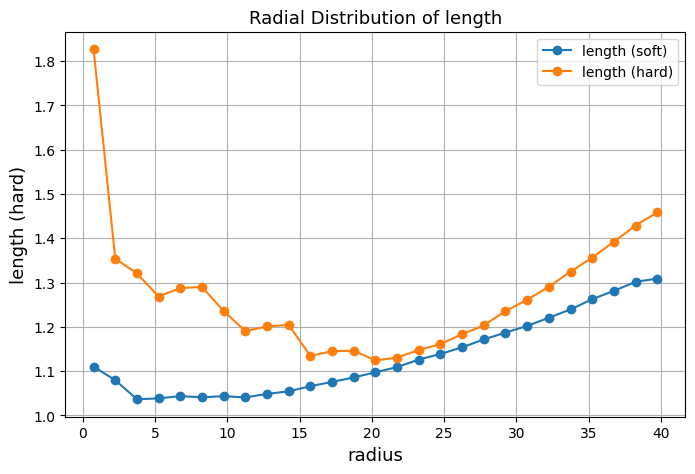

In [1707]:
fig, r_centers, var_vals = plot_radial_distribution(
    particles_soft, "length (soft)", bin_size=1.5)

_ = plot_radial_distribution(particles_hard, "length (hard)", bin_size=1.5, fig=fig)

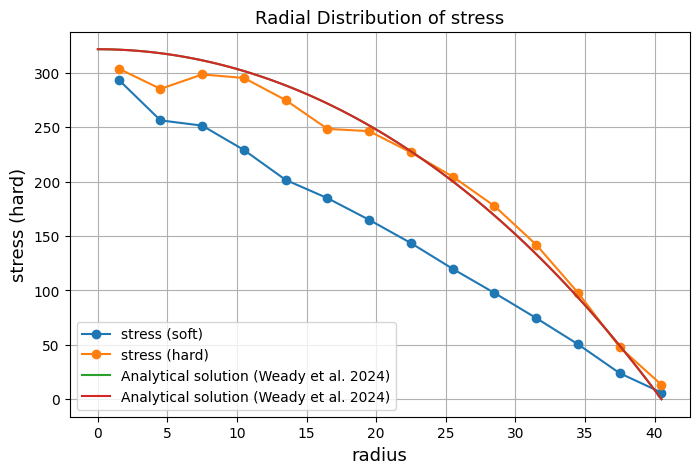

In [1708]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fig, bin_centers1, avg_val = plot_radial_distribution(particles_soft, "stress (soft)", bin_size=3)

fig, bin_centers2, avg_val =plot_radial_distribution(particles_hard, "stress (hard)", fig=fig, bin_size=3)


def pressure_theoretical(r, R, LAMBDA):
    c = (np.sqrt((1 + LAMBDA * R**2 / 2)) - 1) / (2 * LAMBDA * R**2)

    return 2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2)


r1 = np.linspace(0, bin_centers1[-1], 100)
r2  = np.linspace(0, bin_centers2[-1], 100)

ax_stress = fig.axes[0]
ax_stress.plot(r1, pressure_theoretical(r1, bin_centers1[-1], data_soft["parameters"]["LAMBDA"][0]),
               label="Analytical solution (Weady et al. 2024)")
ax_stress.plot(r2, pressure_theoretical(r2, bin_centers2[-1], data_hard["parameters"]["LAMBDA"][0]),
               label="Analytical solution (Weady et al. 2024)")
ax_stress.legend()

In [1709]:
simulation_soft_all

,iteration (soft),simulation_time_s,step_duration_s (soft),step (soft),num_particles (soft),num_constraints (soft),colony_radius (soft),recursive_iterations (soft),bbpgd_iterations (soft),max_overlap (soft),...,memory_usage_mb (soft),peak_memory_mb (soft),cpu_time_s (soft),mpi_comm_time_s (soft),load_imbalance (soft),dt_s (soft),x (soft),y (soft),z (soft),rank (soft)
0,0,0.1000,0.018605,999,1,0,0.302583,0,0,0.0,...,43.3555,43.3555,1.62302,0.000805,16.00000,0.0001,NaN,NaN,NaN,0
0,1,0.2001,0.009158,2000,1,0,0.360756,0,0,0.0,...,43.3555,43.3555,3.44231,0.000673,16.00000,0.0001,NaN,NaN,NaN,0
0,2,0.3002,0.002428,3001,1,0,0.425054,0,0,0.0,...,43.3555,43.3555,4.79858,0.000454,16.00000,0.0001,NaN,NaN,NaN,0
0,3,0.4003,0.004170,4002,1,0,0.496121,0,0,0.0,...,43.3555,43.3555,6.02533,0.000577,16.00000,0.0001,NaN,NaN,NaN,0
0,4,0.5004,0.002088,5003,1,0,0.574670,0,0,0.0,...,43.3555,43.3555,7.19906,0.000888,16.00000,0.0001,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,95,9.6075,0.010872,96074,8192,35380,35.809300,0,0,0.5,...,43.8242,43.8672,488.61900,0.049216,1.62305,0.0001,NaN,NaN,NaN,0
0,96,9.7076,0.010672,97075,8192,36799,37.575800,0,0,0.5,...,43.8594,43.8672,539.06700,0.047617,1.63672,0.0001,NaN,NaN,NaN,0
0,97,9.8077,0.012275,98076,10158,44226,38.212700,0,0,0.5,...,43.9688,43.9688,592.15600,0.053287,1.45855,0.0001,NaN,NaN,NaN,0
0,98,9.9078,0.015197,99077,13336,61399,38.985900,0,0,0.5,...,43.8516,43.9688,669.23800,0.131954,1.39052,0.0001,NaN,NaN,NaN,0


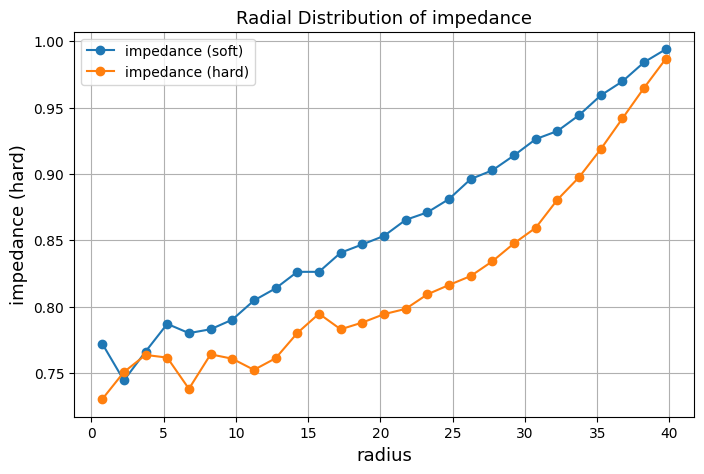

In [1710]:

fig, bin_centers1, avg_val = plot_radial_distribution(particles_soft, "impedance (soft)", bin_size=1.5)

fig, bin_centers2, avg_val =plot_radial_distribution(particles_hard, "impedance (hard)", fig=fig, bin_size=1.5)

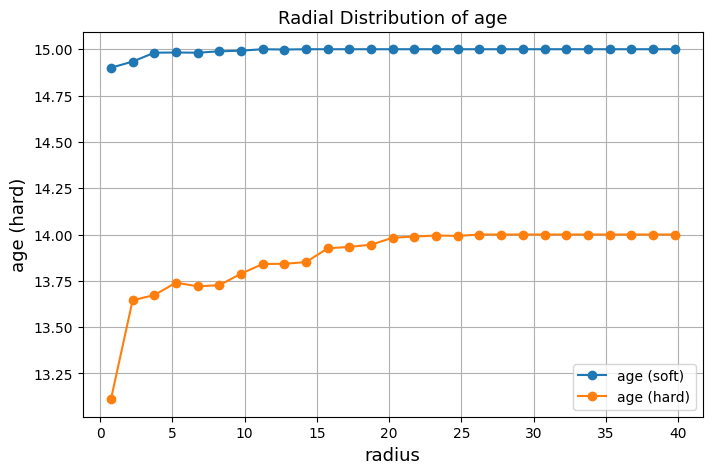

In [1711]:

fig, bin_centers1, avg_val = plot_radial_distribution(particles_soft, "age (soft)", bin_size=1.5)

fig, bin_centers2, avg_val =plot_radial_distribution(particles_hard, "age (hard)", fig=fig, bin_size=1.5)

<Figure size 1000x600 with 0 Axes>

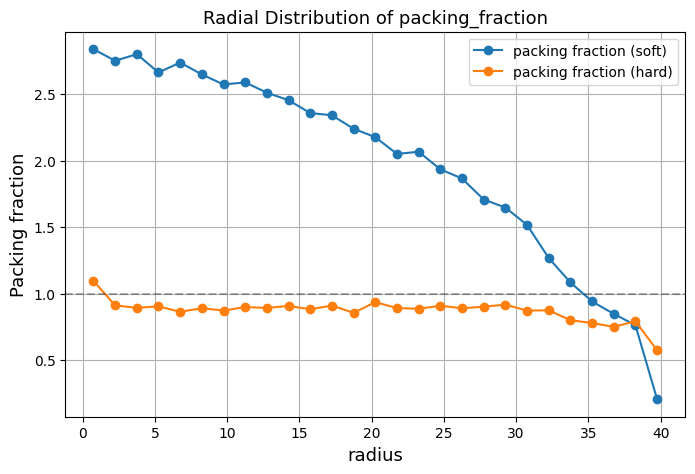

In [1712]:
# Plot packing fractions with smaller bins for better resolution
bin_size = 1.5  # Adjust this value to control smoothness

# Create figure with proper size and margins
fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(right=0.95, left=0.1)  # Adjust margins for better layout

# Plot both packing fractions
fig, r_centers_soft, pf_soft = plot_radial_distribution(particles_soft, 'packing_fraction (soft)', bin_size=bin_size)
_, r_centers_hard, pf_hard = plot_radial_distribution(particles_hard, 'packing_fraction (hard)', bin_size=bin_size, fig=fig)

# Add horizontal line at packing fraction = 1
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='Maximum for hard disks')

plt.show()

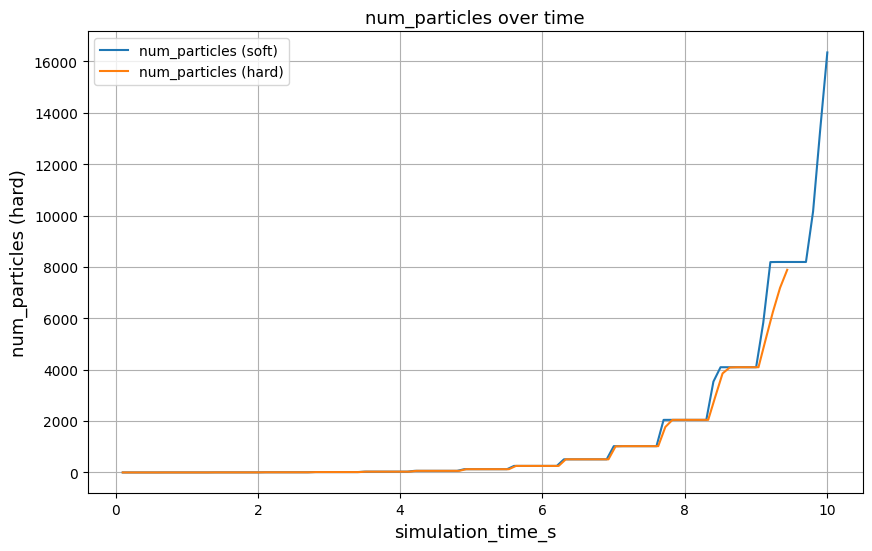

In [1713]:
fig = plot_parameter_over_time(simulation_soft_all, "num_particles (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "num_particles (hard)", fig=fig)

In [1714]:
simulation_soft_all.keys()

Index(['iteration (soft)', 'simulation_time_s', 'step_duration_s (soft)',
       'step (soft)', 'num_particles (soft)', 'num_constraints (soft)',
       'colony_radius (soft)', 'recursive_iterations (soft)',
       'bbpgd_iterations (soft)', 'max_overlap (soft)', 'residual (soft)',
       'memory_usage_mb (soft)', 'peak_memory_mb (soft)', 'cpu_time_s (soft)',
       'mpi_comm_time_s (soft)', 'load_imbalance (soft)', 'dt_s (soft)',
       'x (soft)', 'y (soft)', 'z (soft)', 'rank (soft)'],
      dtype='object')

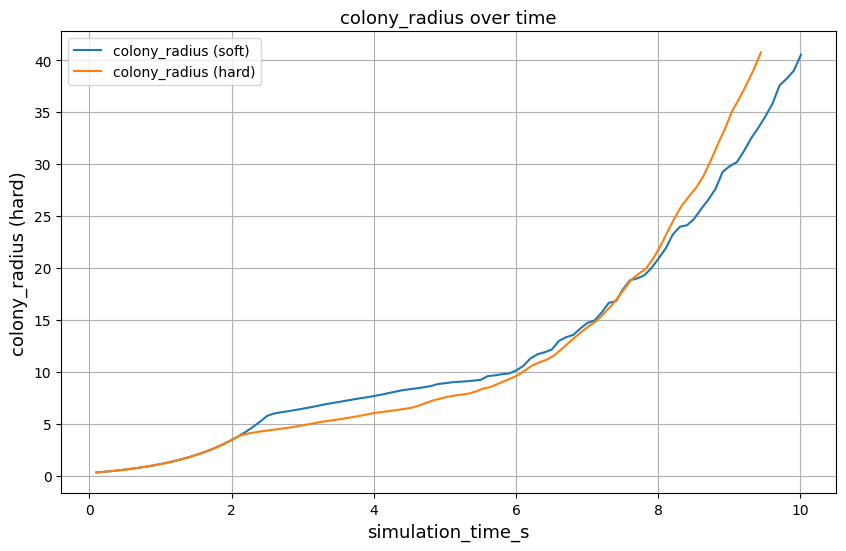

In [1715]:
fig = plot_parameter_over_time(simulation_soft_all, "colony_radius (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "colony_radius (hard)", fig=fig)

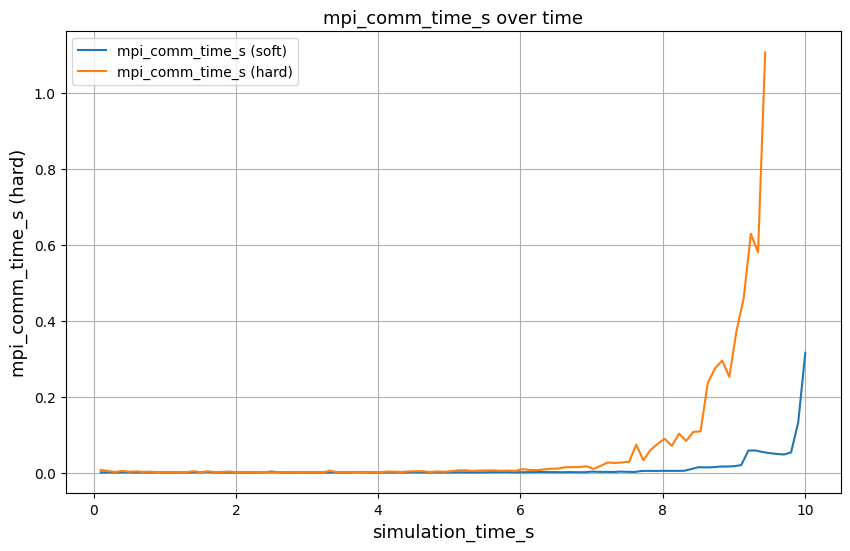

In [1716]:
fig = plot_parameter_over_time(simulation_soft_all, "mpi_comm_time_s (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "mpi_comm_time_s (hard)", fig=fig)

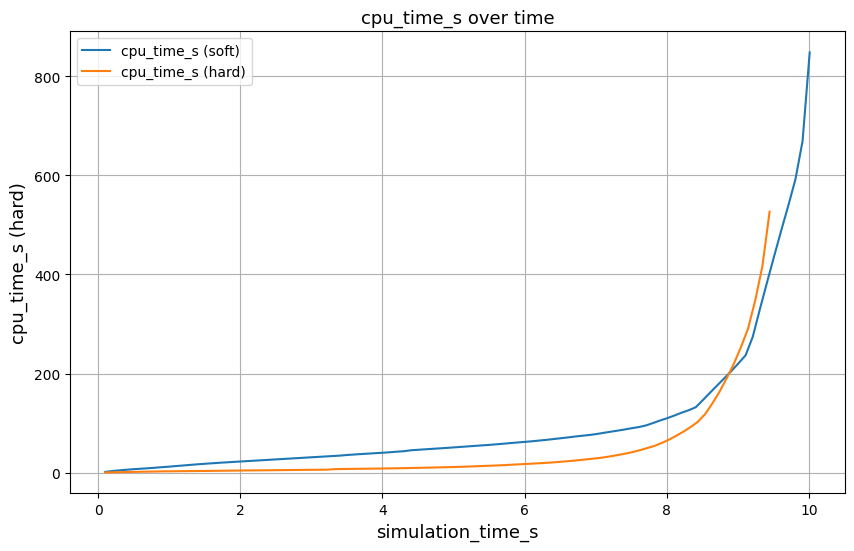

In [1717]:
fig = plot_parameter_over_time(simulation_soft_all, "cpu_time_s (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "cpu_time_s (hard)", fig=fig)